<a href="https://www.kaggle.com/akanksha125/lstm-based-50k-imdb-movie-reviews-classification?scriptVersionId=87872688" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**PROBLEM DESCRIPTION**

This notebook demostrates a **sequence classification of IMDB movie reviews** dataset by creating a simple LSTM based classifier. 

Each movie review is a variable sequence of words, and the tone of each movie review must be classified. The large movie reviews dataset (sometimes referred to as the IMDB dataset) contains *25,000 film reviews (good or bad) for training and 25,000 reviews for testing*. The problem is deciding whether a given movie review is positive or negative. The data were collected by researchers at Stanford  and  used in a 2011 paper that used 50-50  data  for training and testing. An accuracy of 88.89% is achieved. 


**Import modules**

Let's start off with the basic step of importing all the relevant modules and functions required for this particular classifier.

In [1]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
import matplotlib.pyplot as plt
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model


Firstly, let's learn about our dataset. For this we need to import the data and convert it into a Pandas' dataframe.

In [2]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Load and Clean Dataset**

In the original dataset, the reviews are still dirty. There are still html tags, numbers, uppercase, and punctuations. This will not be good for training, so in load_dataset() function, beside loading the dataset using pandas, I also pre-process the reviews by removing html tags, non alphabet (punctuations and numbers), stop words, and lower case all of the reviews.

In [3]:
english_stops = set(stopwords.words('english')) #declaring stop words

def load_dataset():
    df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


The total review count in above data is - 

In [4]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

The data can be visualized by using features of matplotlib library. By doing so, we can the following results,

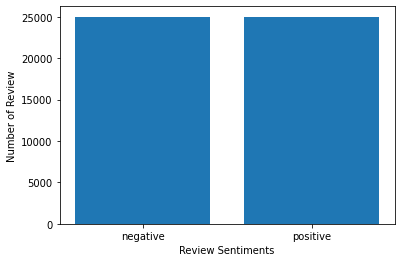

In [5]:
Sentiment_count=df.groupby('sentiment').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['review'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

Next, take the amount of data you want to use for this particular model. The original dataset contains 50,000 movie reviews. But, it can be restricted as per the requirement. 

Then split the dataset into train (70%) and test (30%) sets.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
49200    [a, damsel, distress, definitely, one, fred, a...
22997    [my, dear, lord, movie, let, talk, special, ef...
23223    [they, probably, called, movie, the, map, majo...
35149    [robert, montgomery, myrna, loy, farce, loy, i...
20034    [poorly, acted, poorly, directed, congo, unsuc...
                               ...                        
14266    [the, film, written, years, back, different, d...
48908    [describing, stalingrad, war, film, may, bit, ...
16282    [in, keeping, disney, well, known, practice, s...
13190    [i, impressed, really, i, expected, cheesy, ga...
46732    [the, kid, really, good, family, movie, stuffy...
Name: review, Length: 35000, dtype: object 

48152    [think, film, fan, service, wet, dream, slashe...
43669    [this, hilarious, film, burt, reynolds, nascar...
48420    [first, i, sure, film, aimed, seemed, like, st...
36156    [possible, spoilers, although, good, acting, p...
44759    [i, logged, right, watching, movie, feeling, a...
 

In [7]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))


**Tokenize and Pad/Truncate Reviews**

A Neural Network only accepts numeric data, so we need to encode the reviews.

Each reviews has a different length, so we need to add padding (by adding 0) or truncating the words to the same length (in this case, it is the mean of all reviews length) using tensorflow.keras.preprocessing.sequence.pad_sequences.


In [8]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[   38  9625  6366 ... 33761  2254  8724]
 [  218  2995  1662 ...   792    27   178]
 [  108   146   339 ...     0     0     0]
 ...
 [   49  1900   807 ...     0     0     0]
 [    1  1424    15 ...   121   173    18]
 [    2   421    15 ...     0     0     0]] 

Encoded X Test
 [[   31     4   233 ...    92  7470 50963]
 [    8   479     4 ...     0     0     0]
 [   23     1   156 ...     0     0     0]
 ...
 [ 6074  2403   836 ...     0     0     0]
 [    2  7152  4299 ...  8560 39490  1197]
 [    8     4   295 ...     0     0     0]] 

Maximum review length:  131


**Define the LSTM model**

The first layer is the Embedded layer that uses 32 length vectors to represent each word. The next layer is the LSTM layer with 100 memory units (smart neurons). Subsequently, you can add more than one LSTM layer. Finally, because this is a classification problem we use a Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (good and bad) in the problem.

Because it is a *binary classification problem*, log loss is used as the loss function (binary_crossentropy in Keras). The efficient ADAM optimization algorithm is used. The number of epochs and batch size can be increased as per the requirement. 

In [9]:
# LSTM Model
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 131, 32)           2804320   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,829,217
Trainable params: 2,829,217
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Final evaluation of the model

model.fit(x_train, y_train, batch_size = 256, epochs = 5, callbacks=[checkpoint])

Epoch 1/5


2022-02-15 05:47:48.386035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


137/137 [==============================] - 30s 200ms/step - loss: 0.5714 - accuracy: 0.6615

Epoch 00001: accuracy improved from -inf to 0.66149, saving model to models/LSTM.h5
Epoch 2/5
137/137 [==============================] - 27s 201ms/step - loss: 0.2444 - accuracy: 0.9094

Epoch 00002: accuracy improved from 0.66149 to 0.90937, saving model to models/LSTM.h5
Epoch 3/5
137/137 [==============================] - 27s 200ms/step - loss: 0.1386 - accuracy: 0.9567

Epoch 00003: accuracy improved from 0.90937 to 0.95666, saving model to models/LSTM.h5
Epoch 4/5
137/137 [==============================] - 27s 200ms/step - loss: 0.0764 - accuracy: 0.9781

Epoch 00004: accuracy improved from 0.95666 to 0.97806, saving model to models/LSTM.h5
Epoch 5/5
137/137 [==============================] - 28s 201ms/step - loss: 0.0478 - accuracy: 0.9884

Epoch 00005: accuracy improved from 0.97806 to 0.98843, saving model to models/LSTM.h5


Once the model is created, then we can test the performance on unseen reviews. 

In [11]:
y_pred = model.predict(x_test, batch_size = 128)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

Correct Prediction: 0
Wrong Prediction: 15000
Accuracy: 0.0
